In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [69]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args,
                    leakage=-0.1)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [70]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [71]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [72]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [73]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [74]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [75]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [76]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test ODE Layer

In [77]:
to_phase = Chain(LayerNorm((2,)), x -> tanh_fast.(x))
ps_phase, st_phase = Lux.setup(args.rng, to_phase)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple()), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [78]:
p0, _ = to_phase(x, ps_phase, st_phase)

([0.9711341735396107 -0.1628081753962095 … -0.1339564920906035 -0.07084449409788965; -0.7382633272485227 0.8960409235587877 … -0.39980853999123117 -0.08884499833474777], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

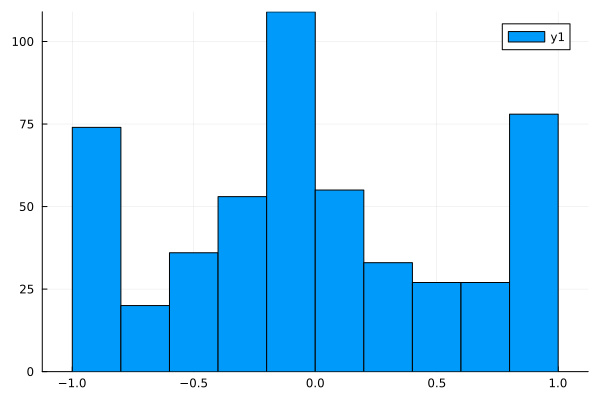

In [79]:
histogram(vec(p0))

In [80]:
stt_phase = st_phase
for (x, _) in train_loader
    _, stt_phase = to_phase(x, ps_phase, stt_phase)
end

In [81]:
ps_phase

(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple())

In [82]:
stt_phase

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [83]:
using ChainRulesCore: ignore_derivatives

In [84]:
function phase_to_current(phases::AbstractArray; spk_args::SpikingArgs)
    function inner(t::Real)
        output = zero(phases)

        ignore_derivatives() do
            times = phases .* spk_args.t_period
            times = mod.(times, spk_args.t_period)

            #add currents into the active synapses
            current_kernel = x -> gaussian_kernel(x, mod(t, spk_args.t_period), spk_args.t_window)
            impulses = current_kernel(times)
            output .+= impulses
        end

        return output
    end

    return inner
end

phase_to_current (generic function with 1 method)

In [85]:
xfn = phase_to_current(x, spk_args=spk_args)

(::var"#inner#100"{SpikingArgs, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}}) (generic function with 1 method)

In [86]:
heatmap(vec(xfn(1.2)))

In [87]:
solver_args

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [88]:
sol_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 20.0), dt = solver_args[:dt], dense=true))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#103),
    layer_3 = WrappedFunction(#104),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
)         # Total: 388 parameters,
          #        plus 0 states.

In [89]:
ps_sol, st_sol = Lux.setup(args.rng, sol_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.03740502 0.007607913; 0.032051656 -0.14364149; … ; 0.17915592 -0.04504438; -0.20711923 0.07185902], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [90]:
y_sol, _ = sol_model(x, ps_sol, st_sol)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dudt#146"{PhasorODE{Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#inner#100"{SpikingArgs, Matrix{Float64}}, @NamedTuple{}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof

In [91]:
u_sol = y_sol |> Array

128×256×2001 Array{ComplexF32, 3}:
[:, :, 1] =
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                     

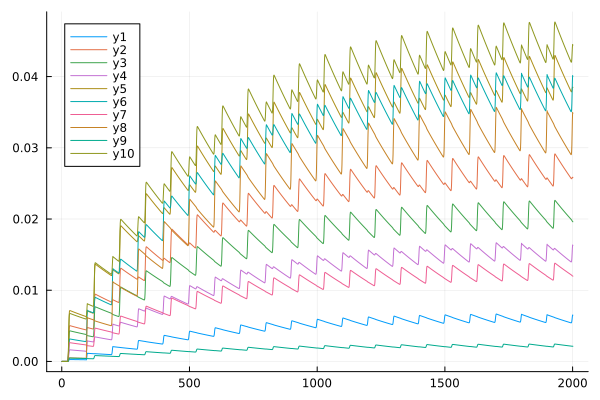

In [92]:
plot(abs.(u_sol[1:10,1,:]'))

In [93]:
pv = solution_to_phase(y_sol, y_sol.t, spk_args=spk_args);

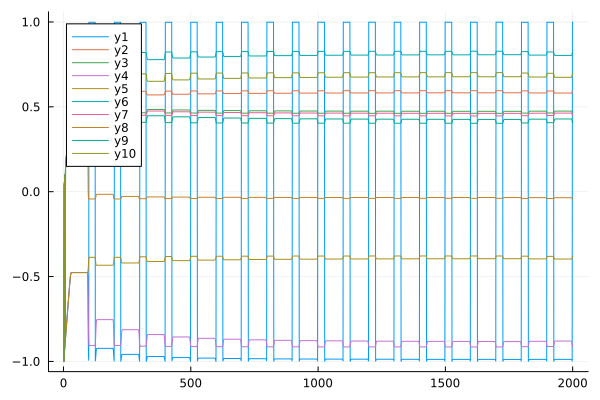

In [94]:
plot(pv[1:10,1,:]')

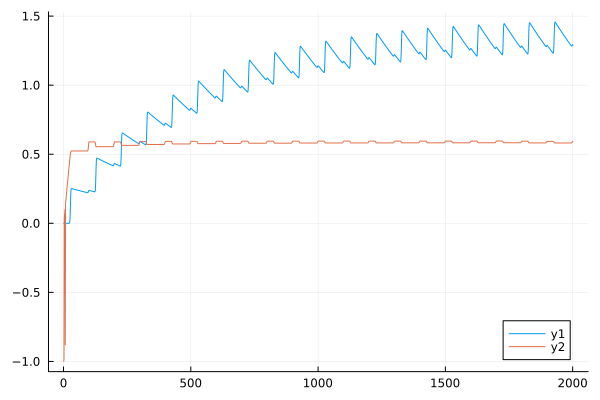

In [96]:
plot(abs.(u_sol[2,1,:]) ./ 0.02)
plot!(pv[2,1,:])

In [27]:
mean(abs.(solution_to_phase(sol_model(x, ps_sol, st_sol)[1], spk_args=spk_args)))

0.4811146624598816

In [28]:
psf_sol = ComponentArray(ps_sol)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.03740502 0.007607913; 0.032051656 -0.14364149; … ; 0.17915592 -0.04504438; -0.20711923 0.07185902], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]))

In [29]:
solution_to_potential(y_sol)

128×256×1 Array{ComplexF32, 3}:
[:, :, 1] =
   0.00021068+8.94792f-7im   …   0.000231303+0.000115728im
  0.000236426+0.000754822im     -0.000532208-0.000356707im
  -7.36044f-5+0.000594796im     -0.000705884-0.000424565im
  0.000508596-0.000137335im      0.000704899+0.000369417im
 -0.000446465-0.00109397im       0.000656897+0.00045967im
   0.00109756+0.000647284im  …   0.000530012+0.000188094im
  -6.26055f-5+0.000360876im     -0.000448061-0.000267501im
  -0.00112022-0.000134408im      -0.00109369-0.000531659im
  -2.00404f-5+6.23542f-5im       -8.75857f-5-5.1312f-5im
  0.000827098+0.00110607im       -0.00025002-0.000257355im
 -0.000203938+0.000387696im  …  -0.000632029-0.000362836im
 -0.000101836+0.000921935im      -0.00108062-0.000651314im
 -0.000845158+0.000675946im      -0.00164164-0.000902882im
             ⋮               ⋱              ⋮
  0.000566028-0.000738219im       0.00139935+0.000788985im
 -0.000922154-0.000370918im     -0.000626938-0.000269653im
 -0.000526547+0.000784685im 

In [30]:
#withgradient(p -> mean(abs.(solution_to_phase(sol_model(x, p, st_sol)[1], spk_args=spk_args))), psf_sol)

In [31]:
ode_model = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt]),
                    x -> solution_to_phase(x, spk_args=spk_args)[:,:,end],
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#45),
    layer_3 = WrappedFunction(#46),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
    layer_5 = WrappedFunction(#47),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [32]:
ps_ode, st_ode = Lux.setup(args.rng, ode_model)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.15707646 -0.044632133; -0.06643613 -0.044867363; … ; -0.027456176 -0.1603537; 0.09821631 0.13010322], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[1.7387471 -1.7479336 … -0.45474225 -0.21259138; -0.49817917 -0.93274075 … -1.2375036 -0.14219837], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [33]:
y_ode, _ = ode_model(x, ps_ode, st_ode)

([-0.9036503487407623 0.7367738732688204 … 0.5649390440251838 0.7897498949514018; 0.882302318484595 0.504073180221312 … 0.7126329366524836 0.1276507768477951], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [34]:
y_ode

2×256 Matrix{Float64}:
 -0.90365   0.736774  -0.843348   0.800166   …  0.863415  0.564939  0.78975
  0.882302  0.504073  -0.660273  -0.0610325     0.881219  0.712633  0.127651

In [35]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.15707646 -0.044632133; -0.06643613 -0.044867363; … ; -0.027456176 -0.1603537; 0.09821631 0.13010322], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = Float32[], layer_6 = (weight = Float32[1.7387471 -1.7479336 … -0.45474225 -0.21259138; -0.49817917 -0.93274075 … -1.2375036 -0.14219837], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [36]:
mean(quadrature_loss(ode_model(x, psf, st_ode)[1], y))

1.0147273778617116

In [37]:
#withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

In [38]:
ode_model_spk = Chain(LayerNorm((2,)), 
                    x -> tanh_fast.(x),
                    x -> phase_to_current(x, spk_args=spk_args),
                    PhasorODE(Chain(Dense(2 => 128)), tspan = (0.0, 10.0), dt = solver_args[:dt], dense=true),
                    MakeSpiking(spk_args, 10, (0.0, 10.0), 0.0),
                    PhasorDenseF32(128 => 2))

Chain(
    layer_1 = LayerNorm((2,), affine=true, dims=Colon()),  # 4 parameters
    layer_2 = WrappedFunction(#51),
    layer_3 = WrappedFunction(#52),
    layer_4 = PhasorODE(
        model = Dense(2 => 128),        # 384 parameters
    ),
    layer_5 = MakeSpiking(),
    layer_6 = PhasorDenseF32((128, 2)),  # 260 parameters
)         # Total: 648 parameters,
          #        plus 0 states.

In [39]:
ps_spk, st_spk = Lux.setup(args.rng, ode_model_spk)

((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.034017395 -0.051840298; 0.20458257 -0.1745663; … ; -0.016001472 0.07038248; -0.14254059 -0.1955896], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_5 = NamedTuple(), layer_6 = (weight = Float32[0.27939907 0.15566063 … 0.21886314 1.2248309; -0.65429574 1.1412214 … -0.5705003 -1.1514217], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [40]:
y_spk, _ = ode_model_spk(x, ps_spk, st_spk)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [65]:
y_spkp = train_to_phase(y_spk.train, spk_args, offset = -0.0);

In [66]:
size(y_spkp)

(10, 2, 256)

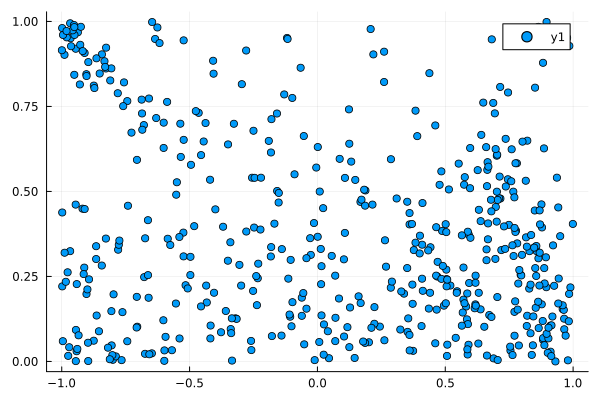

In [71]:
scatter(vec(y_ode), mod.(2.0, 1.0 .+ vec(y_spkp[end-2,:,:])))

In [70]:
cycle_correlation(y_ode, y_spkp)

10-element Vector{Float64}:
 -0.010131064198077175
  0.029888935944375368
 -0.006965313935273541
 -0.0055502037670056925
 -4.94070825525741e-5
 -0.031259763591839414
 -0.05032078617447107
 -0.07014714265660056
 -0.08712005931044295
 -0.037522649400499944